In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class_var = 'annontations'
features = ['Time', 'ankle-x', 'ankle-y', 'ankle-z', 
            'thigh-x', 'thigh-y', 'thigh-z',
            'trunk-x', 'trunk-y', 'trunk-z', class_var]

(65, 11)
(65, 11)


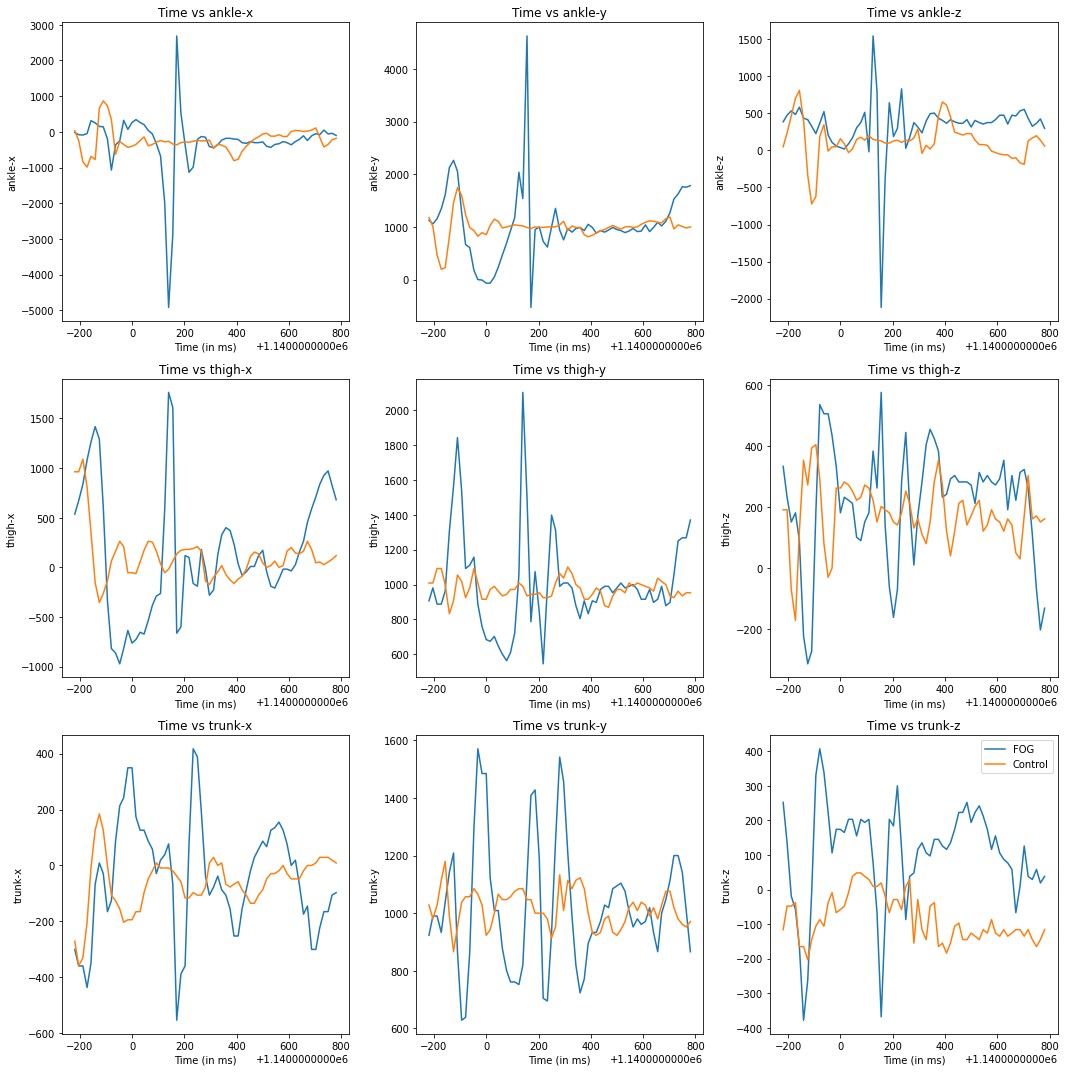

In [3]:
fog_subject = 'S01R01'
control_subject = 'S04R01'

size = 65

fog_df = pd.read_csv('CSV_D/' + fog_subject + '.csv')
fog_df = fog_df[fog_df.annontations == 2].head(size)
time_value = fog_df['Time'].to_list()[0]

fog_df = pd.read_csv('CSV_D/' + fog_subject + '.csv')
fog_df = fog_df[fog_df.Time > time_value].head(size)

control_df = pd.read_csv('CSV_D/' + control_subject + '.csv')
control_df = control_df[control_df.Time > time_value].head(size)

print(fog_df.shape)
print(control_df.shape)

nrows = 3
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i, fname in enumerate(features):
  if fname != 'Time' and fname != class_var:
    plt.subplot(nrows, ncols, i)
    plt.tight_layout()
    plt.title("Time vs " + fname)
    plt.xlabel('Time (in ms)')
    plt.ylabel(fname)
    plt.plot(fog_df.Time, fog_df[fname])
    plt.plot(control_df.Time, control_df[fname])

plt.legend(["FOG", "Control",]) 
plt.show()

In [4]:
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

def load_category(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	loaded = np.dstack(loaded)
	return loaded

def load_dataset_category(category, prefix=''):
  filenames = []
  for fname in features:
    if fname != 'Time' and fname != class_var:
      filenames.append(category + '/' + fname + '_' + category + '.txt')
  
  X = load_category(filenames, prefix)
  y = load_file(prefix + 'y_'+ category +'.txt')
  return X, y

def load_dataset(prefix=''):
  trainX, trainy = load_dataset_category('train', prefix)
  print(trainX.shape, trainy.shape)
  testX, testy = load_dataset_category('test', prefix)
  print(testX.shape, testy.shape)
  trainy = trainy - 1
  testy = testy - 1
  neg, pos = np.bincount(trainy.reshape(1, trainy.shape[0])[0])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))
  trainy = tf.keras.utils.to_categorical(trainy)
  testy = tf.keras.utils.to_categorical(testy)
  # print(trainX.shape, trainy.shape, testX.shape, testy.shape)
  return trainX, trainy, testX, testy, neg, pos, total

In [8]:
trainX, trainy, testX, testy, neg, pos, total = load_dataset('Final_D/')
print("Training Data = ", trainX.shape)
print("Training Class = ", trainy.shape)
print("Test Data = ", testX.shape)
print("Test Class = ", testy.shape)

(7932, 128, 9) (7932, 1)
(3158, 128, 9) (3158, 1)
Examples:
    Total: 7932
    Positive: 717 (9.04% of total)

Training Data =  (7932, 128, 9)
Training Class =  (7932, 2)
Test Data =  (3158, 128, 9)
Test Class =  (3158, 2)


In [9]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

In [52]:
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'


In [53]:
model = build_lstm_model(
    trainX, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                12000     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
 activation_1 (Activation)   (None, 1)                 0         
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
PD_history = model.fit(trainX,
                        trainy,
                        validation_data=(testX, testy),
                        epochs = epochs,
                        batch_size = batch_size,
                        verbose = 1,
                        shuffle=True,
                        class_weight=class_weight)

Epoch 1/20
248/248 [==============================] - 15s 59ms/step - loss: 0.2500 - val_loss: 0.2503
Epoch 2/20
248/248 [==============================] - 16s 63ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 3/20
248/248 [==============================] - 14s 55ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 4/20
248/248 [==============================] - 14s 56ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 5/20
248/248 [==============================] - 13s 53ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 6/20
248/248 [==============================] - 13s 54ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 7/20
248/248 [==============================] - 15s 59ms/step - loss: 0.2500 - val_loss: 0.2502
Epoch 8/20
248/248 [==============================] - 14s 54ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 9/20
248/248 [==============================] - 13s 54ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 10/20
248/248 [==============================] - 14s 56ms/step - loss: 0.250

In [50]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for Test Data = ", conf_acc)
  

In [51]:
model_evaluate(model, [0,1], testX, testy)

Accuracy for Test Data =  89.99366687777074
